This is a simple utility to help pare down the original dataset

In [84]:
import pandas as pd
import re
import os
import zipfile

pd.options.display.max_rows = 999

In [31]:
# Load the Data
df = pd.read_csv('all_data_info.csv')
print(f'Length: {len(df)}')
print(f'{round(df.size_bytes.sum()/1000000000,1)} GB')

# Check for missing values
df.isna().sum()

Length: 103250
40.1 GB


artist              0
date            26363
genre            1254
pixelsx             0
pixelsy             0
size_bytes          0
source            167
style             986
title             122
artist_group        0
in_train            0
new_filename        0
dtype: int64

In [81]:
def clean_date(date_str):
    if pd.isnull(date_str):
        return None
    
    re_ = re.search('(\d\d\d\d?)', date_str)
    if not re_:
        print(f'No match on {date_str}')
        return None
    
    return re_.group(1)

df['date'] = df.date.map(clean_date).astype(float)

In [ ]:
# Look at the breakdowns by style
style_df = df.groupby('style').agg(
    {'size_bytes' : 'sum', 'artist' : 'count', 'date' : 'mean'}).rename(
    {'artist' : 'count'}, axis = 'columns').sort_values('count', ascending = False)

def display_size(bytes_):
    return str(round(bytes_/1000000000,1)) + ' GB'

style_df['size_bytes'] = style_df.size_bytes.map(display_size)
style_df.to_csv('style-breakdown.csv')
print(f'{len(style_df)} styles')
style_df

In [48]:
# Look at the breakdowns by artist
artist_df = df.groupby('artist').agg(
    {'size_bytes' : 'sum', 'new_filename' : 'count'}).rename(
    {'new_filename' : 'count'}, axis = 'columns').sort_values('count', ascending = False)

def display_size(bytes_):
    return str(round(bytes_/1000000,1)) + ' MB'

artist_df['size_bytes'] = artist_df.size_bytes.map(display_size)
artist_df = artist_df[artist_df['count'] >= 100]

artist_df.to_csv('artist-breakdown.csv')
print(f'{len(artist_df)} artists with at least 100 paintings')
artist_df

257 artists with at least 100 paintings


,size_bytes,count
artist,,
John Singer Sargent,154.0 MB,500
Rembrandt,274.1 MB,500
Pablo Picasso,232.4 MB,500
Ivan Shishkin,123.3 MB,500
Ivan Aivazovsky,110.8 MB,500
Giovanni Battista Piranesi,618.3 MB,500
Gustave Dore,352.7 MB,500
Pierre-Auguste Renoir,198.1 MB,500
Ilya Repin,86.0 MB,500


## Process the Files

In [61]:
def get_lookup_dict(col):
    return dict(df.set_index('new_filename')[[col]].to_records())

In [63]:
artist_lookup = get_lookup_dict('artist')
style_lookup  = get_lookup_dict('style')

In [121]:
good_artists = pd.read_excel('artist-breakdown-annotated.xlsx')
good_artists = good_artists[good_artists.fillna(0).keep.astype(bool)].artist.tolist()

In [159]:
to_download = [f'train_{i}' for i in range(0,10)]
to_download.append('test')
to_download = []
to_download

[]

In [160]:
for download_file in to_download:
    if not os.path.exists('./' + download_file + '.zip'):
        print(f'Downloading {download_file}\n'
               'View progress in notebook terminal')
        os.system(f'kaggle competitions download -f {download_file}.zip painter-by-numbers')

    print(f'Extracting {download_file}')
    with zipfile.ZipFile('./' + download_file + '.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    dir_name = f'./{download_file}/'
    print(f'Processing {download_file}')
    image_names = os.listdir(dir_name)

    for file in image_names:
        artist = artist_lookup[file]
        if artist in good_artists:
            os.rename(dir_name + file, './images/' + file)
        else:
            os.remove(dir_name + file)

    os.remove(download_file + '.zip')
    os.removedirs(dir_name)
    print(f'Done with {download_file}\n----------------------------\n')

In [161]:
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


In [167]:
df_trimmed = df[df.artist.isin(good_artists)]

In [170]:
len(df_trimmed.artist.unique())

53

In [168]:
df_trimmed.groupby(['artist', 'style']).apply(len).reset_index()

,artist,style,0
0,Wassily Kandinsky,Abstract Art,133
1,Wassily Kandinsky,Art Nouveau (Modern),3
2,Wassily Kandinsky,Expressionism,55
3,Wassily Kandinsky,Post-Impressionism,23
4,Albrecht Durer,Northern Renaissance,499
5,Amedeo Modigliani,Expressionism,342
6,Andy Warhol,Abstract Expressionism,3
7,Andy Warhol,Naïve Art (Primitivism),1
8,Andy Warhol,Pop Art,183
9,Claude Monet,Impressionism,494


In [172]:
import seaborn as sns

In [171]:
df_trimmed

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
18,Hieronymus Bosch,1515.0,religious painting,8533.0,4325.0,6675952.0,wikiart,Northern Renaissance,The Garden of Earthly Delights,train_and_test,True,82352.jpg
20,Mark Rothko,1968.0,abstract,4912.0,7360.0,4666915.0,wikiart,Abstract Art,Untitled,train_and_test,False,85864.jpg
32,Diego Velazquez,1645.0,self-portrait,4841.0,5947.0,8157404.0,wikiart,Baroque,Self-portrait,train_and_test,True,70728.jpg
37,Titian,1562.0,self-portrait,4524.0,6018.0,8847626.0,wikiart,Mannerism (Late Renaissance),Self-portrait,train_and_test,False,15715.jpg
41,Georges Seurat,1884.0,NaN,6367.0,4226.0,11579390.0,wikipedia,Pointillism,Bathers at Asnières,train_and_test,True,39751.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103090,Andy Warhol,1962.0,advertisement,337.0,450.0,20328.0,wikiart,Pop Art,3 Coke Bottles,train_and_test,True,50089.jpg
103125,M.C. Escher,1946.0,cityscape,356.0,425.0,79585.0,wikiart,Surrealism,"Street in Scanno, Abruzzi",train_and_test,True,73267.jpg
103155,Mark Rothko,1961.0,abstract,500.0,302.0,24397.0,wikiart,Color Field Painting,"No. 14 (Horizontals, White over Darks)",train_and_test,True,8717.jpg
103242,Michelangelo,1509.0,nude painting (nu),314.0,478.0,32773.0,wikiart,High Renaissance,Ignudo,train_and_test,False,12758.jpg


In [173]:
sns.set()

In [177]:
aspect = df_trimmed.pixelsy/df_trimmed.pixelsx

In [179]:
aspect.describe()

count    14703.000000
mean         1.119409
std          0.369298
min          0.055972
25%          0.785904
50%          1.200000
75%          1.352044
max          4.322884
dtype: float64

In [182]:
max_aspect = aspect.apply(lambda x : 1/x if x < 1 else x)

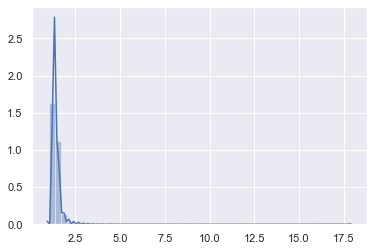

In [183]:
sns.distplot(max_aspect);

In [176]:
df_trimmed.pixelsx.describe()

count    14703.000000
mean      1127.803373
std        594.479816
min        300.000000
25%        722.000000
50%        983.000000
75%       1354.000000
max       8533.000000
Name: pixelsx, dtype: float64

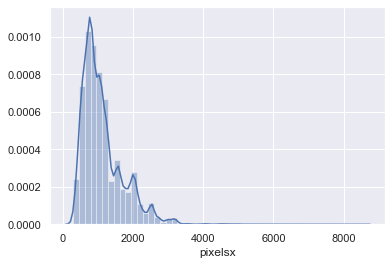

In [175]:
sns.distplot(df_trimmed.pixelsx);

In [186]:
size = df_trimmed.pixelsx * df_trimmed.pixelsy

In [188]:
size.describe()

count    1.470300e+04
mean     1.630612e+06
std      1.843215e+06
min      1.500800e+05
25%      5.755885e+05
50%      9.287950e+05
75%      2.038482e+06
max      3.690522e+07
dtype: float64

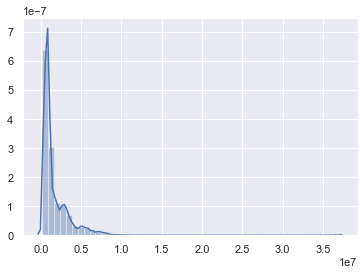

In [187]:
sns.distplot(size);